## Book Recommendation system using K Nearest Neighbor

# **GitHub Link -**
https://github.com/umme-asma/M6_AB_UAS_Recommendation/

# **Item-Based Collaborative Filtering Recommendation System**

The provided code implements an Item-Based Collaborative Filtering Recommendation System tailored for a book recommendation project. This recommendation system relies on the concept that users who enjoyed similar books in the past are likely to have comparable preferences in the future. Here's a step-by-step breakdown of how the system operates:

## ***7. ML Model Implementation usin KNN***

#### Read the dataset with the necessary features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('Books.csv')
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('Users.csv')
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('Ratings.csv')
ratings.columns = ['userID', 'ISBN', 'bookRating']

C:\Users\umme asma\AppData\Local\Temp\ipykernel_2668\3867335242.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv')


In [2]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


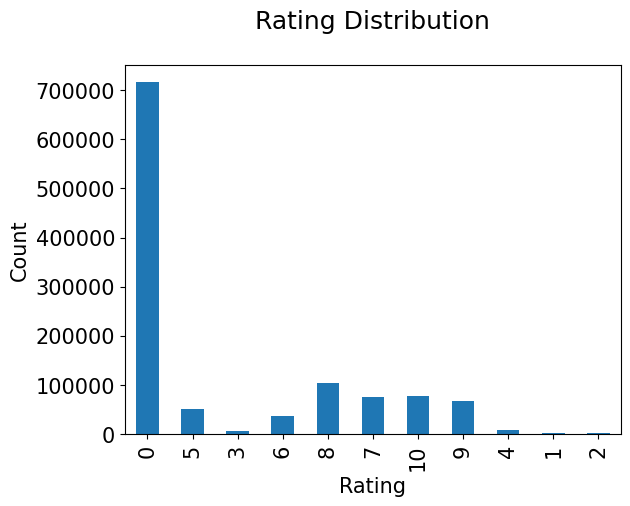

In [3]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [4]:
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [5]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


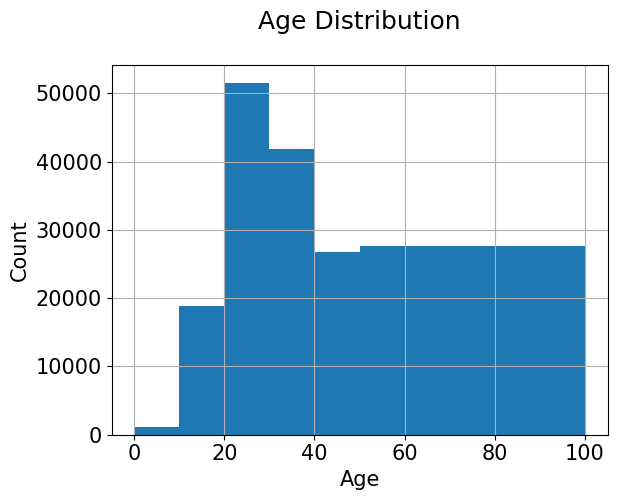

In [6]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

## To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [7]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

## Collaborative Filtering Using k-Nearest Neighbors (kNN)

kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item (book) and one column for each user,

In [8]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,277427,0026217457,0,Vegetarian Times Complete Cookbook
2,277427,003008685X,8,Pioneers
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)"
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels)


We then group by book titles and create a new column for total rating count.

In [9]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


We combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.

In [10]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,7
2,277427,003008685X,8,Pioneers,1
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",1
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),13


In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   160576.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


The median book has been rated only once. Let’s look at the top of the distribution

In [12]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


In [13]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
13,277427,0060930535,0,The Poisonwood Bible: A Novel,133
15,277427,0060934417,0,Bel Canto: A Novel,108
18,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,108
24,277427,006440188X,0,The Secret Garden,79


In [14]:
rating_popular_book.shape

(62149, 5)

## Filter to users in US and Canada only

In [15]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,277427,0060930535,0,The Poisonwood Bible: A Novel,133,"gilbert, arizona, usa"
2,277427,0060934417,0,Bel Canto: A Novel,108,"gilbert, arizona, usa"
3,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,108,"gilbert, arizona, usa"
4,277427,006440188X,0,The Secret Garden,79,"gilbert, arizona, usa"


## Cosine Similarity

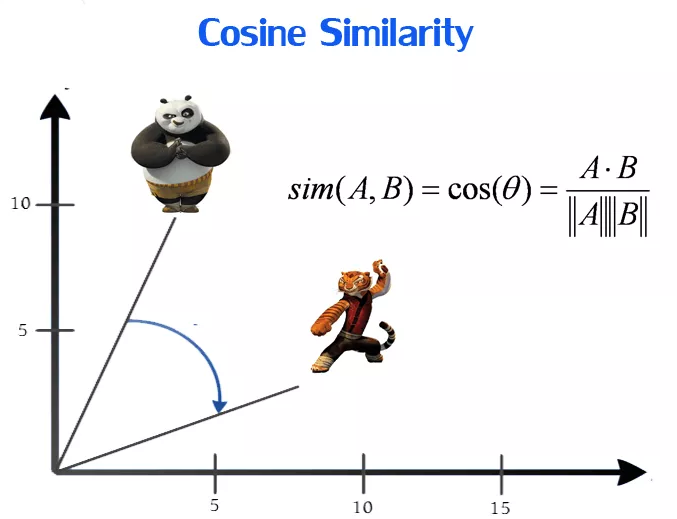

## Implementing kNN
We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

Finding the Nearest Neighbors
We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [16]:
from scipy.sparse import csr_matrix
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [17]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)



287


In [18]:
us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1,-1)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [19]:
us_canada_user_rating_pivot.index[query_index]

'It Was on Fire When I Lay Down on It'

In [20]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for It Was on Fire When I Lay Down on It:

1: All Creatures Great and Small, with distance of 0.6118253214910656:
2: Neverwhere, with distance of 0.7656542855303747:
3: The Two Towers (The Lord of the Rings, Part 2), with distance of 0.771166898270677:
4: The Bonesetter's Daughter, with distance of 0.7820909410595988:
5: The Robber Bride, with distance of 0.7842532070859061:


In [ ]:
### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

In [ ]:
# **Conclusion**

In conclusion, the implemented book recommendation system, utilizing a Nearest Neighbors model, successfully provides users with personalized book suggestions based on a combination of popularity metrics and average ratings. The system's interactivity empowers users to select a book of interest and receive dynamically generated recommendations, enhancing their exploration of the digital library.

Recommendation systems are vital for user engagement, and this project lays a foundation for further improvements. To enhance the system's performance, incorporating additional factors such as user demographics, reading history, or genre preferences could provide more accurate and tailored recommendations. This expansion aligns with business goals to offer a comprehensive and personalized user experience.

Continuous monitoring of the recommendation system's performance using relevant metrics, such as click-through rates or user satisfaction surveys, will be crucial. Feedback from users can guide iterative enhancements, ensuring that the recommendations align with evolving user preferences.

Looking ahead, exploring advanced recommendation algorithms, machine learning techniques, and incorporating real-time user feedback can contribute to a more sophisticated and effective recommendation engine. As the system matures, collaboration with data scientists and user experience experts will be valuable for optimizing algorithms and refining the user interface.

In summary, while the current book recommendation system provides valuable insights into user preferences, there is substantial room for growth. By considering business objectives, incorporating user feedback, and staying abreast of emerging technologies, the recommendation system can evolve into a powerful tool that not only meets but exceeds user expectations, ultimately contributing to positive business impact and sustained user engagement.

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***